## Quickstart  

**Last Modified**: February 10, 2025  

This notebook outlines the machine learning pipeline for implementing the methods proposed in [Agarwal et al. (2024)](https://www.biorxiv.org/content/10.1101/2024.12.28.630628v1). The code is demonstrated on a dummy dataset, and the data is expected to be stored in the following format:  

- root directory
  - individual 1
    - 2022.csv
    - 2023.csv
    - 2024.csv
  - individual 2
    - 2022.csv
    - 2023.csv
  - individual 3
    - 2023.csv
    - 2024.csv

Each acceleration data CSV is expected to have columns 
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| UTC Date[mm/dd]                 | string    | date in format mm/dd                             |
| UTC DateTime                    | string    | time in format HH:MM:SS                          |
| Milliseconds                    | int       | milliseconds (three digits)                      |
| Acc X [g]                       | float     | acceleration reading along X axis                |
| Acc Y [g]                       | float     | acceleration reading along Y axis                |
| Acc Z [g]                       | float     | acceleration reading along Z axis                |
| Temperature [Celsius]           | float     | temperature reading in celsius                   |


The behavior annotations are expected to be a CSV file with columns 
| Column Name           | Data Type | Description                                           |
|-----------------------|-----------|-------------------------------------------------------|
| id                    | string    | individual identification                             |
| Behavior              | string    | behavior label                                        |
| Timestamp_start       | string    | start time of the behavior in format %Y/%m/%d %H:%M:%S|
| Timestamp_end         | string    | end time of the behavior in format %Y/%m/%d %H:%M:%S  |
| Source                | string    | source of behavior label (eg. audio/video)            |

Before running this notebook, make sure to edit the `config/settings.py` file. Instructions for what each variable specifies are included in the script.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch
import sys
import os
import time
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime, timedelta
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

In [2]:
import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.io as io
import src.utils.data as data

In [3]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams['legend.fontsize'] = 40
mpl.rcParams['axes.titlesize'] = 40
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## 0. Create Test Data

In [ ]:
# Define individuals and years of dataset available for them
individuals = {"individual_1": [2022, 2023, 2024],
               "individual_2": [2022, 2023],
               "individual_3": [2023, 2024]}

# Create directories and generate acceleration data
os.makedirs(config.TEST_ROOT_DIR, exist_ok=True)

# generate random accelerometry data for i day
for individual, years in individuals.items():
    individual_dir = config.TEST_PATHS[individual]
    os.makedirs(individual_dir, exist_ok=True)
    
    for year in years:
        start_time = datetime(year, 1, 1)
        end_time = datetime(year, 1, 1, 23, 59, 59)
        time_delta = timedelta(seconds=1/config.SAMPLING_RATE)
        
        timestamps = []
        while start_time <= end_time:
            timestamps.append(start_time)
            start_time += time_delta
        
        data = {
            "UTC Date[mm/dd]": [t.strftime("%m/%d") for t in timestamps],
            "UTC DateTime": [t.strftime("%H:%M:%S") for t in timestamps],
            "Milliseconds": [t.microsecond // 1000 for t in timestamps],
            "Acc X [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Acc Y [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Acc Z [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Temperature [Celsius]": np.random.uniform(20, 30, len(timestamps))
        }
        
        df = pd.DataFrame(data)
        df.to_csv(os.path.join(individual_dir, f"{year}.csv"), index=False)

# Generate behavior annotations
def generate_behavior_annotations(individuals, years):
    behavior_data = []
    for individual, years in individuals.items():
        for year in years:
            start_time = datetime(year, 1, 1)
            end_time = datetime(year, 1, 1, 23, 59, 59)
            
            num_behaviors = np.random.randint(10, 20)
            for _ in range(num_behaviors):
                behavior_start = start_time + timedelta(days=np.random.randint(0, 365), 
                                                        hours=np.random.randint(0, 24), 
                                                        minutes=np.random.randint(0, 60))
                behavior_end = behavior_start + timedelta(seconds=np.random.randint(5, 120))
                
                if behavior_end > end_time:
                    behavior_end = end_time
                
                behavior_data.append([individual, 
                                      np.random.choice(config.BEHAVIORS), 
                                      behavior_start.strftime("%Y/%m/%d %H:%M:%S"),
                                      behavior_end.strftime("%Y/%m/%d %H:%M:%S"),
                                      "Video"])
    
    return pd.DataFrame(behavior_data, 
                        columns=["id", "Behavior", "Timestamp_start", "Timestamp_end", "Source"])

behavior_df = generate_behavior_annotations(individuals, years)
behavior_df.to_csv(config.TEST_ANNOTATIONS_PATH, index=False)


## 1 Creating Data Objects

#### 1.1 Create segments by reading accelerometry CSV in chunks

For reading the CSV files, orgnaized in the format decsribed above, we run the following function. `run_vectronics` creates segments by reading accelerometer data in chunks and saves the half-day segments in a 
directory titled `combined_acc` inside the data directory of each individual.

**Parameters:**
- **path_mappings** (dict): A dictionary where keys are individual names (str) and values are file paths (str) to their data directories.
- **max_chunks** (int, optional): The maximum number of chunks to process per individual. Default is 0 (no limit).

The half-day chunks are saved with two extra columns:
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| Timestamp                       | string    | complete timestamp in format `%m/%d/%Y %H:%M:%S` |
| date_am_pm_id                   | string    | half day timestampe in format `%m/%d/%Y_%P`      |


In [4]:
create_segments_and_metadata.run_vectronics(config.TEST_PATHS, max_chunks=5)

Processing individual:         test
Files for this individual :    ['2023.csv']
Handling the csv:              /mnt/ssd/medhaaga/wildlife/Vectronics/test/2023.csv
Number of half days in chunk:  2



#### 1.2 Create metadata

The function `create-metadata` generates metadata for the saved half-day segments of accelerometer data.

**Parameters:**
- **path_mappings** (dict): A dictionary where keys are individual names (str) and values are file paths (str) to their data directories.
- **metadata_path** (str): The file path where the generated metadata CSV file will be saved.

**Metadata columns:**
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| file path                       | string    | Path-like object of where the half-day segment is stored |
| individual ID                   | string    | Unique identifier for an individual             |
| year                            | int       | Year of behavior observation                    |
| UTC Date [yyyy-mm-dd]           | string    | Date of behavior observation                    |
| am/pm                           | string    | AM or PM time of behavior observation           |
| half day [yyyy-mm-dd_am/pm]     | string    | Half-day of behavior observation                |
| avg temperature [C]             | float     | Average temperature on the half-day of behavior observation |


In [5]:
create_segments_and_metadata.create_metadata(config.TEST_PATHS, config.TEST_METADATA_PATH)

Dog test has 2 halfdays.


100%|██████████| 2/2 [00:00<00:00, 41.39it/s]


In [6]:
metadata = pd.read_csv(config.TEST_METADATA_PATH)
metadata.head()

,file path,dog ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,/mnt/ssd/medhaaga/wildlife/Vectronics/test/com...,test,2023,2023-01-26,am,2023-01-26_am,21.698332
1,/mnt/ssd/medhaaga/wildlife/Vectronics/test/com...,test,2023,2023-02-09,pm,2023-02-09_pm,0.000000


#### 1.3 Match the accelerometry segments with available annotations

Here we use the function `combined_annotations` to combine the video and audio annotations in a shared format. We cal also read the pre-ready annotations file. The annotations are expected to have follwoing columns.

**Annotations columns:**
| Column Name                     | Data Type | Description                                           |
|---------------------------------|-----------|-------------------------------------------------------|
| id                              | string    | individual identification                             |
| Behavior                        | string    | behavior label                                        |
| Timestamp_start                 | string    | start time of the behavior in format %Y/%m/%d %H:%M:%S|
| Timestamp_end                   | string    | end time of the behavior in format %Y/%m/%d %H:%M:%S  |
| Source                          | string    | source of annotation (eg. video/audio)                |

In [5]:
# specify the expected format for annotations, add instructions for loading these annotations.
all_annotations = data_prep_utils.combined_annotations(config.TEST_VIDEO_ANNOTATIONS_PATH, config.TEST_AUDIO_ANNOTATIONS_PATH, config.id_mapping)
all_annotations.to_csv(config.TEST_ANNOTATIONS_PATH)
all_annotations = pd.read_csv(config.TEST_ANNOTATIONS_PATH)
all_annotations.head()

,Unnamed: 0,id,Behavior,Timestamp_start,Timestamp_end,Source
0,0,test,Standing,2021-11-01 03:50:16,2021-11-01 03:50:33,Video
1,1,test,Walking,2021-11-01 03:50:33,2021-11-01 03:50:34,Video
2,2,test,Standing,2021-11-01 03:50:34,2021-11-01 03:52:00,Video
3,3,test,Walking,2021-11-01 03:52:00,2021-11-01 03:52:01,Video
4,4,test,Standing,2021-11-01 03:52:02,2021-11-01 03:52:36,Video


#### 1.4 Match annotations and acceleration data

The function `create_matched_data` matches the files in metadata with available annotations (both in formats discussed above).

**Arguments:**
filtered_metadata: pandas dataframe with columns ['file path', 'individual ID', 'year', 'UTC Date [yyyy-mm-dd]', 'am/pm', 'half day [yyyy-mm-dd_am/pm]', 'avg temperature [C]']
annotations: pandas dataframe with columns ['id', 'Behavior', 'Timestamp_start', 'Timestamp_end', 'Source']

**Returns**:

acc_summary: pandas dataframe = summary of the matched acceleration files with columns 

| Column Name            | Data Type | Description                                           |
|------------------------|-----------|-------------------------------------------------------|
| id                     | string    | individual indentification                            |
| date_am_pm_id          | string    | half day description in format yyyy-mm-dd_{am/pm}     |
| annotations            | string    | behavior label                                        |
| acc                    | float     | matched acceleration duration                         |
| number of matched acc  | int       | number of matched annotations in the half day         |

acc_data: pandas dataframe = final matched windows of acc data  with columns

| Column Name            | Data Type | Description                                           |
|------------------------|-----------|-------------------------------------------------------|
| individual ID          | string    | individual indentification                            |
| behavior               | string    | behavior label                                        |
| behavior_start         | float     |start time in format %Y/%m/%d %H:%M:%S                 |
| behavior_end           | float     |end time in format %Y/%m/%d %H:%M:%S                   |
| duration               | float     |duration of the matched behavior                       |
| year                   | int       |year of behavior observation                           |
| UTC Date [yyyy-mm-dd]  | string    |date of behavior observation                           |
| am/pm                  | string    |date of behavior observation                           |
| half day [yyyy-mm-dd_am/pm] | string    |half day of behavior observation                  |
| avg temperature [C]    | string    |date of behavior observation                           |
| acc_x                  | list object| acceleration data along X axis                       |
| acc_y                  | list object| acceleration data along Y axis                       |
| acc_z                  | list object| acceleration data along Z axis                       |
| Source                 | string     | source of behavior annotation (video, audio, etc)    |

acc_data_metadata: pandas dataframe = metadata of the acceleration segments matched with annotations

| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| file path                       | string    | Path-like object of where the half-day segment is stored |
| individual ID                   | string    | Unique identifier for an individual             |
| year                            | int       | Year of behavior observation                    |
| UTC Date [yyyy-mm-dd]           | string    | Date of behavior observation                    |
| am/pm                           | string    | AM or PM time of behavior observation           |
| half day [yyyy-mm-dd_am/pm]     | string    | Half-day of behavior observation                |
| avg temperature [C]             | float     | Average temperature on the half-day of behavior observation |


In [7]:
acc_summary, acc_data, acc_data_metadata = create_matched_data_objects.create_matched_data(metadata, all_annotations)

Dog test has 2 halfdays in the filtered metadata.


Processing unique half days for test: 100%|██████████| 2/2 [00:00<00:00, 996.51it/s]


In [8]:
print("\nAcc Summary:")
print(acc_summary.head())

print("\nAcc Data:")
print(acc_data.head())

print("\nAcc Data Metadata:")
print(acc_data_metadata.head())


Acc Summary:
     id  date_am_pm_id  annotations  acc  number of matched acc
0  test  2023-01-26_am            0  0.0                      0
1  test  2023-02-09_pm            0  0.0                      0

Acc Data:
Empty DataFrame
Columns: [dog ID, behavior, behavior_start, behavior_end, duration, year, UTC Date [yyyy-mm-dd], am/pm, half day [yyyy-mm-dd_am/pm], avg temperature [C], acc_x, acc_y, acc_z, Source]
Index: []

Acc Data Metadata:
Empty DataFrame
Columns: [file path, dog ID, year, UTC Date [yyyy-mm-dd], am/pm, half day [yyyy-mm-dd_am/pm], avg temperature [C]]
Index: []


In [9]:
acc_summary = pd.read_csv(io.get_matched_summary_path())
acc_data = pd.read_csv(io.get_matched_data_path())
acc_data_metadata = pd.read_csv(io.get_matched_metadata_path())

In [ ]:
# view acc_summary, acc_data, acc_data_metadata
acc_summary.head()

In [11]:
acc_data.head()

,dog ID,behavior,behavior_start,behavior_end,duration,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C],acc_x,acc_y,acc_z,Source
0,jessie,Lying (head up),2022-08-12 05:38:32.008000+00:00,2022-08-12 05:39:05.945000+00:00,33.937,2022,2022-08-12,am,2022-08-12_am,22.37426,"[0.81, 0.88, 0.88, 0.88, 0.81, 0.81, 0.88, 0.8...","[0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.3...","[-0.44, -0.44, -0.44, -0.44, -0.44, -0.44, -0....",Video
1,jessie,Lying (head down),2022-08-12 05:39:06.008000+00:00,2022-08-12 05:41:44.945000+00:00,158.937,2022,2022-08-12,am,2022-08-12_am,22.37426,"[0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.69, 0.6...","[0.38, 0.38, 0.44, 0.44, 0.38, 0.44, 0.44, 0.4...","[-0.56, -0.56, -0.56, -0.56, -0.56, -0.56, -0....",Video
2,jessie,Lying (head up),2022-08-12 05:41:45.008000+00:00,2022-08-12 05:42:33.945000+00:00,48.937,2022,2022-08-12,am,2022-08-12_am,22.37426,"[-0.06, -0.06, -0.06, -0.06, -0.06, -0.06, -0....","[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.19, 0.3...","[-0.81, -0.81, -0.81, -0.81, -0.81, -0.81, -0....",Video
3,jessie,Lying (head down),2022-08-12 05:42:34.008000+00:00,2022-08-12 05:42:47.945000+00:00,13.937,2022,2022-08-12,am,2022-08-12_am,22.37426,"[0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.31, 0.3...","[0.44, 0.44, 0.44, 0.44, 0.44, 0.38, 0.44, 0.4...","[-0.75, -0.75, -0.75, -0.69, -0.69, -0.75, -0....",Video
4,jessie,Lying (head up),2022-08-12 05:42:48.008000+00:00,2022-08-12 05:43:03.945000+00:00,15.937,2022,2022-08-12,am,2022-08-12_am,22.37426,"[0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.31, 0.3...","[0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.3...","[-0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0....",Video


In [12]:
acc_data_metadata.head()

,file path,dog ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.37426
1,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.37426
2,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.37426
3,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.37426
4,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.37426


Don't run the code below if matched data is already saved. The following function does the following:
- combine video and audio annotations
- match the annotations with accelerometry data pointed by the metadata
- save the data objects - `acc_summary`, `acc_data`, and `acc_data_metadata` in a `data` folder in the project root directory

In [13]:
match_behaviors(config.TEST_METADATA_PATH, config.TEST_VIDEO_ANNOTATIONS_PATH, config.TEST_AUDIO_ANNOTATIONS_PATH)

Dog test has 2 halfdays in the filtered metadata.


Processing unique half days for test: 100%|██████████| 2/2 [00:00<00:00, 1109.75it/s]


## 2. Training a Classification Model  

### 2.1 Creating Metadata Filters for Train and Test Data  

Metadata filters are dictionary objects where the keys correspond to all metadata columns except `file_path`. The values associated with each key are list-like objects specifying the values to be included in the filter. If a key has a value of `None`, it indicates no filtering based on that column.  

Below is an example metadata filter for an interdog experiment:  


{
    'dog ID': ['jessie', 'palus', 'ash', 'fossey'],
    'year': None,
    'UTC Date [yyyy-mm-dd]': None,
    'am/pm': None,
    'half day [yyyy-mm-dd_am/pm]': None,
    'avg temperature [C]': None
}

Make sure to edit the function `get_exp_filter_profiles` to describe the train-test splits


In [33]:
train_filter_profile, test_filter_profile = data.get_exp_filter_profiles('no_split')
print('NO SPLIT')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

print('\n')

train_filter_profile, test_filter_profile = data.get_exp_filter_profiles('interdog')
print('INTERDOG')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

NO SPLIT
train filter    {'dog ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'dog ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


INTERDOG
train filter    {'dog ID': ['jessie', 'palus', 'ash', 'fossey'], 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'dog ID': ['green'], 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


In [34]:
# load metadata
metadata = pd.read_csv(config.VECTRONICS_METADATA_PATH)
metadata.head()

,file path,dog ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-07-29,am,2022-07-29_am,0.000000
1,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-10-05,am,2022-10-05_am,29.104619
2,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2023,2023-02-08,am,2023-02-08_am,30.062104
3,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2023,2023-01-04,am,2023-01-04_am,27.291044
4,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-24,pm,2022-08-24_pm,24.162662


In [35]:
# load annotations
all_annotations = data_prep_utils.combined_annotations(video_path=config.VECTRONICS_VIDEO_ANNOTATIONS_PATH, 
                                            audio_path=config.VECTRONICS_AUDIO_ANNOTATIONS_PATH,
                                            id_mapping=config.id_mapping) # load annotations 
all_annotations.head()

,id,Behavior,Timestamp_start,Timestamp_end,Source
0,ash,Standing,2021-11-01 03:50:16,2021-11-01 03:50:33,Video
1,ash,Walking,2021-11-01 03:50:33,2021-11-01 03:50:34,Video
2,ash,Standing,2021-11-01 03:50:34,2021-11-01 03:52:00,Video
3,ash,Walking,2021-11-01 03:52:00,2021-11-01 03:52:01,Video
4,ash,Standing,2021-11-01 03:52:02,2021-11-01 03:52:36,Video


In [56]:
class Arguments:
        def __init__(self, experiment_name, 
                     batch_size, 
                     window_duration_percentile,
                     train_test_split,
                     train_val_split,
                     padding, 
                     theta,
                     filter_type,
                     cutoff_frequency,
                     cutoff_order,
                     normalization,
                     match,
                     min_duration,
                     n_CNNlayers,
                     n_channels,
                     kernel_size,
                     learning_rate,
                     weight_decay,
                     num_epochs,
                     alpha):
                self.experiment_name = experiment_name
                self.batch_size = batch_size
                self.window_duration_percentile = window_duration_percentile
                self.train_test_split = train_test_split
                self.train_val_split = train_val_split
                self.padding = padding
                self.theta = theta
                self.filter_type = filter_type
                self.cutoff_frequency = cutoff_frequency
                self.cutoff_order = cutoff_order
                self.normalization = normalization
                self.match = match
                self.min_duration = min_duration
                self.n_CNNlayers = n_CNNlayers
                self.n_channels = n_channels
                self.kernel_size = kernel_size
                self.learning_rate = learning_rate
                self.weight_decay = weight_decay,
                self.num_epochs = num_epochs,
                self.alpha = alpha


args = Arguments(experiment_name='interdog', 
                batch_size=64, 
                window_duration_percentile=50, 
                train_test_split=0.2, 
                train_val_split=0.2, 
                padding='repeat', 
                theta=0.8, 
                filter_type='high', 
                cutoff_frequency=0, 
                cutoff_order=5, 
                normalization=0,
                match=0,
                min_duration=1.0,
                n_CNNlayers=5,
                n_channels=32,
                kernel_size=5,
                learning_rate=0.0001,
                weight_decay=0.0001,
                num_epochs = 100,
                alpha = 0.05)

Create train and test splits based on the experimental split of choice. Create dataloaders for the datasets. The fnunction `setup_data_objects` create the 

**Arguments**:

| Column Name                     | Data Type        | Description                                      |
|---------------------------------|------------------|--------------------------------------------------|
| metadata                        | Pandas Dataframe | metadata of all acceleration segments            |
| all_annotations                 | Pandas Dataframe | available annotations                            |
| collapse_behavior_mapping       | dictionary       | mapping from fine to coarse behavior classes     |
| behaviors                       | list             | list of behaviors of interest for classification |
| args                            | dictionary       | training arguments                               |
| match                           | bool             | whether to match behaviors or use a pre-saved dataframe   |

**Returns**:


| Column Name | Data Type            | Description                                                                           |
|-------------|----------------------|---------------------------------------------------------------------------------------|
| X_train     | (n, d, T) np ndarray | train acceleration, n = no. of samples, d = no. of features, T = time axis            |
| y_train     | (n, K) np ndarray    | train labels, n = no. of samples, K = one-hot vector for the K classes behavior label |
| z_train     | pandas dataframe     | metadata associated with the train observations                                       |
| X_val       | (n, d, T) np ndarray | val   acceleration, n = no. of samples, d = no. of features, T = time axis            |
| y_val       | (n, K) np ndarray    | val labels, n = no. of samples, K = one-hot vector for the K classes behavior label   |
| z_val       | pandas dataframe     | metadata associated with the validation observations                                  |
| X_test      | (n, d, T) np ndarray | test acceleration, n = no. of samples, d = no. of features, T = time axis             |
| y_test      | (n, K) np ndarray    | test labels, n = no. of samples, K = one-hot vector for the K classes behavior label  |
| z_test      | pandas dataframe     | metadata associated with the test observations                                        |
 

In [38]:
start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = data.setup_data_objects(metadata, 
                                                                                                    all_annotations, 
                                                                                                    config.COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    config.BEHAVIORS, 
                                                                                                    args, 
                                                                                                    reuse_behaviors=config.BEHAVIORS)

print("Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))
train_dataloader, val_dataloader, test_dataloader = data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print('Shape of dataframes')
print("==========================")
print(f"Train: -- X: {train_dataloader.dataset.tensors[0].shape}, Y: {train_dataloader.dataset.tensors[1].shape}, Z: {z_train.shape}")
print(f"Val: -- X: {val_dataloader.dataset.tensors[0].shape}, Y: {val_dataloader.dataset.tensors[1].shape}, Z: {z_val.shape}")
print(f"Test: -- X: {test_dataloader.dataset.tensors[0].shape}, Y: {test_dataloader.dataset.tensors[1].shape}, Z: {z_test.shape}")


Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 6311
No overlaps. 
no. of train observations: 4402, no. of test observations: 1909

Matching annotations to acceleration snippets takes 80.183043 seconds
Creating fixed-duration windows takes 25.350392 seconds.

Time series duration window = 12.937
Class distribution
      0
0   229
1   501
2  8247
3   143
4  3984


Creating data objects takes 105.92 seconds.

Shape of dataframes
Train: -- X: torch.Size([13104, 3, 206]), Y: torch.Size([13104, 5]), Z: (13104, 7)
Val: -- X: torch.Size([3277, 3, 206]), Y: torch.Size([3277, 5]), Z: (3277, 7)
Test: -- X: torch.Size([6987, 3, 206]), Y: torch.Size([6987, 5]), Z: (6987, 7)


In [45]:
#########################################
#### Model, loss, and optimizer
#########################################

from src.methods.prediction_model import create_dynamic_conv_model
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                    num_conv_layers=args.n_CNNlayers, 
                                    base_channels=args.n_channels, 
                                    kernel_size=args.kernel_size).to(device)

print("")
print("==================================")
print(f"Number of trainable model paramters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)


Number of trainable model paramters: 887237


In [51]:
#############################################
###### Training & Saving 
##############################################

from src.utils.train import (training_loop,
                             multi_label_eval_loop)

# Train

epochs = args.num_epochs

avg_train_losses, avg_test_losses = [], []
best_val_loss = 100
training_stats = []

print("")
print("Training...")
print("=============================")

start_time = time.time()

for epoch in tqdm(range(epochs)):

    model.train()

    t0 = time.time()

    total_train_loss = training_loop(model, optimizer, criterion, train_dataloader, device=device)

    t1 = time.time()

    with torch.no_grad():
        val_loss, val_true_classes, val_predictions, val_scores = multi_label_eval_loop(model, criterion, val_dataloader, device=device)

    t2 = time.time()
    
    if val_loss < best_val_loss:

        # calculate test scores
        with torch.no_grad():
            test_loss, test_true_classes, test_predictions, test_scores = multi_label_eval_loop(model, criterion, test_dataloader, device=device)

        best_val_loss, best_val_predictions, best_val_scores = val_loss, val_predictions, val_scores
    
    # save train and test loss every 10 epochs 
    
    avg_train_loss = total_train_loss/len(train_dataloader)
    avg_train_losses.append(avg_train_loss)
    avg_test_losses.append(val_loss)

    if (epoch+1)%10 == 0:
        print("")
        print(f'========= Epoch {epoch+1}/{epochs} ==========')
        print(f"Average train loss: {avg_train_loss}")
        print(f" Average val loss: {val_loss}")    
        print(f" Best val loss: {best_val_loss}, best test loss: {test_loss}")   

    training_stats.append(
    {
        "epoch": epoch + 1,
        "Training Loss": avg_train_loss,
        "Validation Loss": val_loss,
        "Training Time": io.format_time(t1 - t0),
        "Validation Time": io.format_time(t2 - t1),
    }
    ) 

end_time = time.time()
print("")
print("=======================")
print(f'Total training time: {io.format_time(end_time-start_time)}')    


Training...


 10%|█         | 10/100 [00:17<02:34,  1.72s/it]


========= Epoch 10/100 ==========
Average train loss: 0.08779759666905171
 Average val loss: 0.09589736253166428
 Best val loss: 0.09589736253166428, best test loss: 0.12114529599943621


 20%|██        | 20/100 [00:33<02:11,  1.64s/it]


========= Epoch 20/100 ==========
Average train loss: 0.08229074123792532
 Average val loss: 0.09176604134532121
 Best val loss: 0.08883965316300209, best test loss: 0.11183060269845142


 30%|███       | 30/100 [00:50<01:55,  1.64s/it]


========= Epoch 30/100 ==========
Average train loss: 0.07878275558170748
 Average val loss: 0.08479429666812603
 Best val loss: 0.08330302114168611, best test loss: 0.11708825171226636


 40%|████      | 40/100 [01:06<01:38,  1.64s/it]


========= Epoch 40/100 ==========
Average train loss: 0.07514125285897313
 Average val loss: 0.08373741354220189
 Best val loss: 0.08123911644976872, best test loss: 0.11479172528382729


 50%|█████     | 50/100 [01:22<01:21,  1.63s/it]


========= Epoch 50/100 ==========
Average train loss: 0.0702736173324832
 Average val loss: 0.08279767587709312
 Best val loss: 0.08123911644976872, best test loss: 0.11479172528382729


 60%|██████    | 60/100 [01:38<01:04,  1.62s/it]


========= Epoch 60/100 ==========
Average train loss: 0.07205690304498846
 Average val loss: 0.08008510461793496
 Best val loss: 0.07933933526062621, best test loss: 0.11027648894708943


 70%|███████   | 70/100 [01:54<00:46,  1.54s/it]


========= Epoch 70/100 ==========
Average train loss: 0.07093099241213101
 Average val loss: 0.07995519049179095
 Best val loss: 0.07933933526062621, best test loss: 0.11027648894708943


 80%|████████  | 80/100 [02:10<00:32,  1.60s/it]


========= Epoch 80/100 ==========
Average train loss: 0.06678174412468585
 Average val loss: 0.07845659869221541
 Best val loss: 0.07770050899125636, best test loss: 0.11459951531353661


 90%|█████████ | 90/100 [02:26<00:15,  1.59s/it]


========= Epoch 90/100 ==========
Average train loss: 0.06677708120607748
 Average val loss: 0.08607968179365763
 Best val loss: 0.07647879394845894, best test loss: 0.11452452592255379


100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


========= Epoch 100/100 ==========
Average train loss: 0.06617496671473108
 Average val loss: 0.07869088929146528
 Best val loss: 0.07594803163710122, best test loss: 0.11007662699134513

Total training time: 0:02:42


In [52]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.12410948216551687,
  'Validation Loss': 0.1295219068057262,
  'Training Time': '0:00:01',
  'Validation Time': '0:00:00'},
 {'epoch': 2,
  'Training Loss': 0.10621713650662724,
  'Validation Loss': 0.12179557678218071,
  'Training Time': '0:00:02',
  'Validation Time': '0:00:00'},
 {'epoch': 3,
  'Training Loss': 0.10287509956737843,
  'Validation Loss': 0.10823910454144844,
  'Training Time': '0:00:01',
  'Validation Time': '0:00:00'},
 {'epoch': 4,
  'Training Loss': 0.10083231361719167,
  'Validation Loss': 0.1094787004045569,
  'Training Time': '0:00:02',
  'Validation Time': '0:00:00'},
 {'epoch': 5,
  'Training Loss': 0.09830197481120505,
  'Validation Loss': 0.10683710224783191,
  'Training Time': '0:00:02',
  'Validation Time': '0:00:00'},
 {'epoch': 6,
  'Training Loss': 0.09973289917518453,
  'Validation Loss': 0.10232016537338495,
  'Training Time': '0:00:02',
  'Validation Time': '0:00:00'},
 {'epoch': 7,
  'Training Loss': 0.0937554935129

In [57]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *

cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=args.alpha, lamda_criterion='size').to(device)

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 52/52 [00:00<00:00, 528.21it/s]


Optimal T=0.19216731190681458


In [59]:
## fit a label encoder

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)

LabelEncoder()

In [70]:
print(f"{'Label encoding for [Feeding, Running]:':<40} {label_encoder.transform(['Feeding', 'Running'])}")
print(f"{'Label for encoding [2, 3]:':<40} {label_encoder.inverse_transform([2, 3])}")


Label encoding for [Feeding, Running]:   [0 3]
Label for encoding [2, 3]:               ['Resting' 'Running']



The true behavior is Feeding and the RAPS is ['Vigilant' 'Feeding'] with scores [0.29496986 0.22843494]

The true behavior is Moving and the RAPS is ['Moving'] with scores [0.40127724]

The true behavior is Resting and the RAPS is ['Resting'] with scores [0.39845937]

The true behavior is Running and the RAPS is ['Running' 'Moving'] with scores [0.27208373 0.23337957]

The true behavior is Vigilant and the RAPS is ['Vigilant'] with scores [0.37752402]


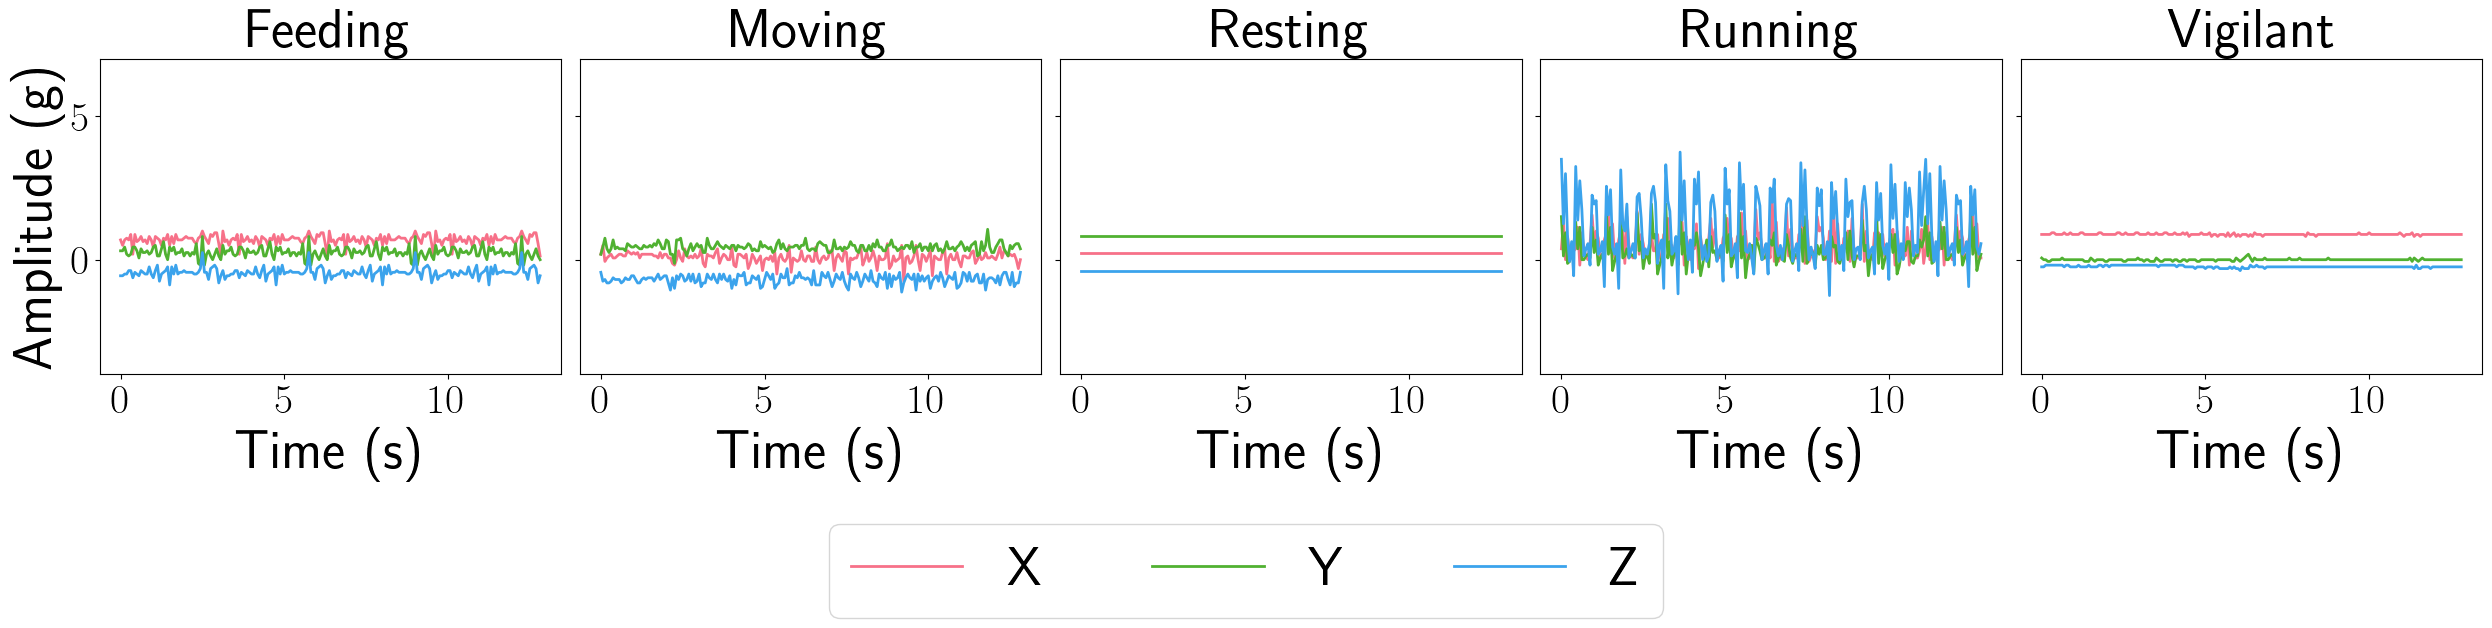

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

idx = [np.random.choice(np.where(y_test == i)[0]) for i in range(len(config.BEHAVIORS)) ]
colors = sns.color_palette('husl', 3)

fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for n,i in enumerate(idx):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        logits, set = cmodel(acc.unsqueeze(0).to(device))
        logits_numpy = logits.detach().cpu().numpy()
        scores = softmax(logits_numpy, axis=1)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=2)
        axs[n].set_title(target)
        axs[n].set_ylim(-4, 7)
        axs[n].set_xlabel('Time (s)')
    print("")
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center',
        bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.show()